# Q-learning算法

$$Q(s, a) \leftarrow Q(s, a) + \alpha \cdot \left( r + \gamma \cdot \max_{a'} Q(s', a') - Q(s, a) \right)$$
表达的含义就是， 当前Q的更新，等于我当前状态的即时奖励，加上,下一个状态s'的最大Q减当前的Q值，再乘一个学习率。  时序差分的思想

$$\pi(s) = \arg\max_a Q(s, a)
$$

最后的策略即为，始终选取令Q最大的动作$

Sarsa(state-action-reward-s'-a')与Q-learning不同的是: 

Q-learning是拿s'下最大的Q'更新当前Q，但是下回合不一定采取该动作a'，下回合的动作依旧由epsilon-greedy决定；

而Sarsa则在当前直接用epsilon-greedy确定好了s'以及a'，在s'时一定执行a'，所以它用的a'所对应的Q值更新当前Q。

In [4]:
import gymnasium as gym # 导入gym模块
import numpy as np 
import matplotlib.pyplot as plt
import torch
import math

In [5]:
env = gym.make('CliffWalking-v0') # 定义环境

n_states = env.observation_space.n # 状态数
n_actions = env.action_space.n # 动作数
print(f"状态数：{n_states}，动作数：{n_actions}")

状态数：48，动作数：4


In [6]:
env.observation_space  # 状态空间为离散的48个值，不是连续的状态空间

Discrete(48)

In [7]:
state, _ = env.reset()
print(f"初始状态：{state}")

初始状态：36


In [8]:
#定义Q learning类
class base_Q_learning():
    def __init__(
        self,env,
        max_steps_per_eos = 200,         # 每个更新epoch走的最大步数 
        gamma = 0.5,                     # 折扣因子
        alpha = 0.1,                     # 步长大小、学习率；
        sample_count = 0,                # 总采样数，不会随epoch重置，用于epsilon的衰减函数设计。
        epsilon_start = 0.1,             # e-greedy策略中epsilon的起始值
        epsilon_end = 0.005,             # e-greedy策略中epsilon的最终值
        epsilon_decay = 0.01,            # e-greedy策略中epsilon的衰减率，decay越大，衰减的越快
        epsilon_decay_flag = True        # e-greedy策略中epsilon是否衰减
    ):
        self.env = env
        self.max_steps_per_eos = max_steps_per_eos
        self.state_num = self.env.observation_space.n
        self.action_num = self.env.action_space.n
        self.gamma = gamma
        self.alpha = alpha
        self.sample_count = sample_count
        self.epsilon = epsilon_start
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon_decay = epsilon_decay
        self.epsilon_decay_flag = epsilon_decay_flag
        self.Q = np.zeros((self.state_num, self.action_num))   # 创建Q表格，共有n_state行、n_action列
        self.total_rewards = []                                  # 记录回报
    
    def epsillon_greedy_action(self, state):
        # epsillon衰减
        if self.epsilon_decay_flag:
            self.epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                math.exp(-1. * self.sample_count *  self.epsilon_decay)  # epsilon是会递减的，这里选择指数递减。
        else:
            self.epsilon = self.epsilon_start

        # e-greedy采样策略
        if np.random.rand() < self.epsilon:             # 小于epsilon，随机探索一个新的动作
            return np.random.randint(self.action_num)
        else:                                           
            if np.count_nonzero(self.Q[state]) != 0:    # 如果当前状态下的动作不全为0的话
                return np.argmax(self.Q[state])         # 贪心，选择当前Q值最大的动作
            else:
                return np.random.randint(self.action_num) # 否则的话就随机选一个动作

    #与环境进行交互，更新Q表，计算收益
    def train(self, epochs):
    
        # 一共迭代epochs个回合，每个回合里与环境交互max_steps_per_eos次
        for epoch in range(epochs):
            self.cur_state, _ = self.env.reset()
            
            for i in range(self.max_steps_per_eos):
                self.sample_count += 1                                   # 因为全程用的都是一个Q表，Q表没有reset，所以e的衰减应该是伴随Q更新的全程一起的
                a = self.epsillon_greedy_action(self.cur_state)          # 采用Q-learning+epsillon_greedy选取动作
                next_s, reward, over,  _, info = self.env.step(a)        # 执行动作a，得到环境的反馈
                if over:
                    break
                self.update_q_table(self.cur_state, a, next_s, reward)   # 往前走一步后更新Q表，根据公式需要的有Q0，r，Q1，a，gamma
                self.cur_state = next_s                                  # 状态发生变化，但下一个状态的a仍是由e-greedy决定的；Sarsa这一步需要确定好a

            # 计算当前Q表的总奖励
            total_reward = self.evaluate()
            self.total_rewards.append(total_reward)                 # 用于后续绘图观察变化
            print(f"epoch: {epoch}, total_reward: {total_reward}")  # 实时记录是否收敛
            
            ################################# 以下是内部互调用函数，不在外部使用   ##########################################
    #根据Qlearning算法更新Q表
    def update_q_table(self, s, a, next_s, r):  
        s = int(s)
        a = int(a)
        next_s = int(next_s)
        Q_target = r + self.gamma * np.max(self.Q[next_s])                    # 这步是Q-learning的精髓了，时序差分目标
        self.Q[s][a] = self.Q[s][a] + self.alpha * (Q_target - self.Q[s][a])  # 更新Q表

    # 策略评估
    def evaluate(self):
        Q = self.Q
        env = self.env
        s, _ = env.reset()
        total_reward = 0.0 
        for i in range(self.max_steps_per_eos):           # 最多只能走num_steps步
            a = np.argmax(Q[s])                           # 根据Q表贪心地取出每步最大的a
            next_s, reward, done, _, info = env.step(a)   # 根据a往前走一步，返回数据
            total_reward += reward                        # 累计奖励
            if done: 
                break
            s = int(next_s)
        return total_reward

In [9]:
def learning_curve(epoch, total_rewards):
    plt.plot(epoch, total_rewards)
    plt.xlabel('Epoch')
    plt.ylabel('Rewards')
    plt.title('Q-learning')
    plt.show()

In [10]:
# 用于测试的主函数，需要输入环境，训练轮数；
if __name__ == '__main__':
    epochs = 1000
    env = gym.make('CliffWalking-v0', render_mode = 'rgb_array')  # 生成实验环境，这里选取悬崖寻路环境CliffWalking-v0，可供选取的环境还包括FrozenLake-v0，Roulette-v0，FrozenLake8x8-v0，Taxi-v3
    env.reset()
    agent = base_Q_learning(env)
    agent.train(epochs)
    env.close()  # 关掉环境

epoch: 0, total_reward: -200.0
epoch: 1, total_reward: -200.0
epoch: 2, total_reward: -200.0
epoch: 3, total_reward: -200.0
epoch: 4, total_reward: -200.0
epoch: 5, total_reward: -200.0
epoch: 6, total_reward: -200.0
epoch: 7, total_reward: -200.0
epoch: 8, total_reward: -200.0
epoch: 9, total_reward: -200.0
epoch: 10, total_reward: -200.0
epoch: 11, total_reward: -200.0
epoch: 12, total_reward: -200.0
epoch: 13, total_reward: -200.0
epoch: 14, total_reward: -200.0
epoch: 15, total_reward: -200.0
epoch: 16, total_reward: -200.0
epoch: 17, total_reward: -200.0
epoch: 18, total_reward: -200.0
epoch: 19, total_reward: -200.0
epoch: 20, total_reward: -200.0
epoch: 21, total_reward: -200.0
epoch: 22, total_reward: -200.0
epoch: 23, total_reward: -200.0
epoch: 24, total_reward: -200.0
epoch: 25, total_reward: -200.0
epoch: 26, total_reward: -200.0
epoch: 27, total_reward: -200.0
epoch: 28, total_reward: -200.0
epoch: 29, total_reward: -200.0
epoch: 30, total_reward: -200.0
epoch: 31, total_r

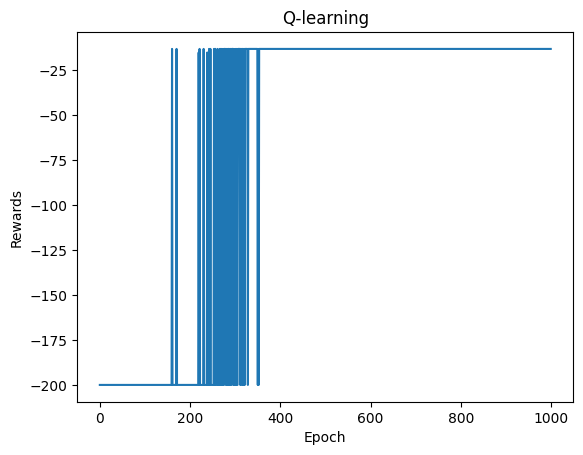

In [11]:
learning_curve(range(epochs), agent.total_rewards)

In [12]:
# 做当前的最优策略
def best_policy(agent):
    env = gym.make('CliffWalking-v0', render_mode = 'human')  
    cur_state, _ = env.reset()
    over = False
    while not over:
        a = np.argmax(agent.Q[cur_state])
        next_s, _, over,  _, _ = env.step(a)
        cur_state = next_s
    env.close()  # 关掉环境

In [13]:
best_policy(agent)

In [14]:
agent.Q

array([[ -1.99792755,  -1.99791155,  -1.9979293 ,  -1.99792989],
       [ -1.99703566,  -1.99704361,  -1.99713662,  -1.99713289],
       [ -1.99529656,  -1.99536485,  -1.99548453,  -1.99554095],
       [ -1.99253718,  -1.99231606,  -1.99245007,  -1.99270152],
       [ -1.9875012 ,  -1.98710408,  -1.98695178,  -1.98720442],
       [ -1.97808673,  -1.97791232,  -1.97802519,  -1.97831537],
       [ -1.96147456,  -1.96177729,  -1.96204776,  -1.96306893],
       [ -1.93565548,  -1.93392754,  -1.93333977,  -1.93618094],
       [ -1.88687675,  -1.88488714,  -1.88387617,  -1.88823294],
       [ -1.80106302,  -1.80236345,  -1.79970133,  -1.80195439],
       [ -1.66783323,  -1.66218091,  -1.65945707,  -1.66862499],
       [ -1.44522085,  -1.44522085,  -1.45044147,  -1.45379827],
       [ -1.99845446,  -1.99842383,  -1.9984488 ,  -1.99847417],
       [ -1.99754139,  -1.99748848,  -1.99749547,  -1.99751391],
       [ -1.99581351,  -1.99576796,  -1.99577594,  -1.99588167],
       [ -1.99260191,  -1